# Advanced DL and RL: Домашнее задание 1
Студент: Клюенков Владимир

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
        
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
* hit  — взять ещё одну карту;
* stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py


#### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [249]:
import gym
env = gym.make('Blackjack-v0', natural=True)
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [250]:
%%time
num_episodes = 1000000
average_reward = 0

def simplest_policy(state):
    if state[0] >= 19: 
        return 0
    else:
        return 1
    
    
for i in range(num_episodes):
    state = env.reset()
    is_done = False
    while not is_done:
        action = simplest_policy(state)
        state, reward, is_done, _ = env.step(action)
    average_reward += (reward - average_reward) / (i + 1)
    
print(f"Выигрыш от наивной стратегии: {average_reward}")

Выигрыш от наивной стратегии: -0.17964350000000046
CPU times: user 1min 7s, sys: 122 ms, total: 1min 8s
Wall time: 1min 8s


#### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

####  Q-обучение

In [253]:
class Qlearning:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        env == 'Blackjack-v0'
        self.env = gym.make('Blackjack-v0', natural=True)
        self.na = self.env.action_space.n
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for n in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        #print(f"Средний выигрыш после {num_episodes} эпизодов Q-learning: {average_reward}")
        return average_reward

In [256]:
%%time
QL = Qlearning()
QL.train(num_episodes=1000000)
average_reward = QL.inference(num_episodes=100000)

CPU times: user 1min 57s, sys: 834 ms, total: 1min 58s
Wall time: 1min 58s


In [257]:
print(f"Средний выигрыш Q-learning: {average_reward}")

Средний выигрыш Q-learning: -0.051329999999999903


#### Monte Carlo control

In [259]:
from collections import defaultdict
import random
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    #print(f"Средний выигрыш после {num_episodes} эпизодов Monte Carlo control: {average_reward}")
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], env.action_space.n)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [260]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
MC_inference(Q_mc, num_episodes=100000)

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.03512999999999976


-0.03512999999999976

#### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Попробуем подобрать оптимальные параметры при помощи grid search.

#### Grid search q-learning and plot

In [80]:
%%time
best_sum_of_rewards = -0.18 # need better that dummy strategy
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.0001, 0.01, 15)):
    for eps in np.linspace(0.05, 0.5, 15):
        QL = Qlearning(alpha=alpha, eps=eps)
        QL.train(10000)
        sum_of_rewards = QL.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")


100%|██████████| 15/15 [31:29<00:00, 125.94s/it]

Лучший выигрыш: -0.042539999999999634, alpha: 0.0001, eps: 0.4035714285714286
CPU times: user 31min 20s, sys: 14.3 s, total: 31min 34s
Wall time: 31min 29s


In [97]:
%%time
QL = Qlearning(alpha=0.0001, eps=0.40357)
sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    QL.train(1000)
    sum_of_rewards = QL.inference()
    sums_of_rewards.append(sum_of_rewards)


100%|██████████| 100/100 [15:31<00:00,  9.31s/it]

CPU times: user 15min 19s, sys: 6.68 s, total: 15min 26s
Wall time: 15min 36s


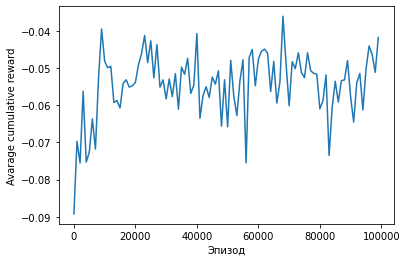

In [99]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

#### Grid search Monte Carlo control and plot

In [126]:
%%time
best_sum_of_rewards = -0.18 # need better that dummy strategy
best_gamma = 0

for gamma in tqdm(np.linspace(0., 1, 100)):
    Q_mc, evaluations = monte_carlo(gamma=1., episodes=5000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    if sum_of_rewards > best_sum_of_rewards:
        best_sum_of_rewards = sum_of_rewards
        best_gamma = gamma

print(f"Лучший выигрыш: {best_sum_of_rewards}, best_gamma: {best_gamma}")



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:06<11:30,  6.97s/it]

  2%|▏         | 2/100 [00:14<11:35,  7.10s/it]

  3%|▎         | 3/100 [00:21<11:21,  7.02s/it]

  4%|▍         | 4/100 [00:28<11:21,  7.10s/it]

  5%|▌         | 5/100 [00:36<11:51,  7.49s/it]

  6%|▌         | 6/100 [00:45<12:17,  7.84s/it]

  7%|▋         | 7/100 [00:54<12:41,  8.19s/it]

  8%|▊         | 8/100 [01:03<12:58,  8.46s/it]

  9%|▉         | 9/100 [01:12<13:07,  8.66s/it]

 10%|█         | 10/100 [01:21<13:12,  8.81s/it]

 11%|█         | 11/100 [01:30<13:10,  8.89s/it]

 12%|█▏        | 12/100 [01:39<12:49,  8.74s/it]

 13%|█▎        | 13/100 [01:47<12:16,  8.46s/it]

 14%|█▍        | 14/100 [01:55<11:53,  8.30s/it]

 15%|█▌        | 15/100 [02:03<11:35,  8.18s/it]

 16%|█▌        | 16/100 [02:11<11:41,  8.35s/it]

 17%|█▋        | 17/100 [02:19<11:26,  8.27s/it]

 18%|█▊        | 18/100 [02:27<11:05,  8.12s/it]

 19%|█▉        | 19/100 [02:35<10:54,  8.08s/it]

 20%|██        |

Лучший выигрыш: -0.07829500000000111, best_gamma: 0.6060606060606061
CPU times: user 12min 48s, sys: 6.53 s, total: 12min 55s
Wall time: 1h 28min 1s


кажется что gamma = 1 всё же лучше, но чтобы убедиться наверняка нужно гридсёрчить обучая на бОльшем числе эпизодов

In [132]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(50)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)




  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:49,  5.90s/it]


  4%|▍         | 2/50 [00:13<05:00,  6.26s/it]


  6%|▌         | 3/50 [00:20<05:10,  6.61s/it]


  8%|▊         | 4/50 [00:27<05:05,  6.65s/it]


 10%|█         | 5/50 [00:34<05:12,  6.95s/it]


 12%|█▏        | 6/50 [00:43<05:27,  7.45s/it]


 14%|█▍        | 7/50 [00:51<05:30,  7.70s/it]


 16%|█▌        | 8/50 [01:00<05:41,  8.14s/it]


 18%|█▊        | 9/50 [01:08<05:29,  8.03s/it]


 20%|██        | 10/50 [01:17<05:32,  8.32s/it]


 22%|██▏       | 11/50 [01:26<05:33,  8.55s/it]


 24%|██▍       | 12/50 [01:36<05:43,  9.03s/it]


 26%|██▌       | 13/50 [01:45<05:35,  9.05s/it]


 28%|██▊       | 14/50 [01:55<05:30,  9.18s/it]


 30%|███       | 15/50 [02:06<05:38,  9.67s/it]


 32%|███▏      | 16/50 [02:17<05:45, 10.15s/it]


 34%|███▍      | 17/50 [02:28<05:39, 10.28s/it]


 36%|███▌      | 18/50 [02:38<05:29, 10.29s/it]


 38%|███▊      | 19/50 [02:49<05:27, 10.57s/it]


 40%|████      

CPU times: user 9min 45s, sys: 5.42 s, total: 9min 51s
Wall time: 9min 50s


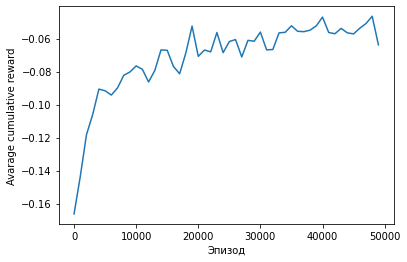

In [133]:
plt.plot(range(0,50000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

In [134]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=0.6, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)




  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:05<08:40,  5.26s/it]


  2%|▏         | 2/100 [00:12<09:20,  5.72s/it]


  3%|▎         | 3/100 [00:19<09:57,  6.15s/it]


  4%|▍         | 4/100 [00:27<10:43,  6.71s/it]


  5%|▌         | 5/100 [00:35<11:18,  7.15s/it]


  6%|▌         | 6/100 [00:42<11:20,  7.24s/it]


  7%|▋         | 7/100 [00:50<11:36,  7.48s/it]


  8%|▊         | 8/100 [00:59<12:09,  7.93s/it]


  9%|▉         | 9/100 [01:08<12:33,  8.28s/it]


 10%|█         | 10/100 [01:18<12:58,  8.65s/it]


 11%|█         | 11/100 [01:28<13:19,  8.98s/it]


 12%|█▏        | 12/100 [01:38<13:47,  9.40s/it]


 13%|█▎        | 13/100 [01:48<14:01,  9.67s/it]


 14%|█▍        | 14/100 [01:59<14:06,  9.84s/it]


 15%|█▌        | 15/100 [02:09<13:58,  9.86s/it]


 16%|█▌        | 16/100 [02:19<14:07, 10.09s/it]


 17%|█▋        | 17/100 [02:30<14:20, 10.37s/it]


 18%|█▊        | 18/100 [02:41<14:22, 10.52s/it]


 19%|█▉        | 19/100 [02:52<14:19, 10.61s/i

CPU times: user 25min 43s, sys: 12.5 s, total: 25min 56s
Wall time: 25min 55s


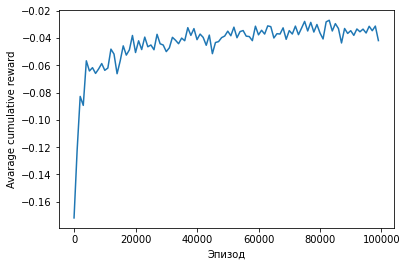

In [136]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:


* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


#### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [147]:
class Doubled_Blackjack_V0_Env:
    def __init__(self):
        self.base_env = gym.make('Blackjack-v0')
        self.action_space = list(range(3))
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            
            state, reward, is_done, _ = self.base_env.step(1)
            
            if done:
                return state, 2*reward, is_done, _
            
            else:
                
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2*reward, is_done, _
            
        else:
            return self.base_env.step(action)

In [139]:
class Qlearning_Doubled_Blackjack:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.env = Doubled_Blackjack_V0_Env()
        self.na = 3
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for n in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        #print(f"Средний выигрыш после {num_episodes} эпизодов Q-learning: {average_reward}")
        return average_reward

In [261]:
%%time
QL_Doubled = Qlearning_Doubled_Blackjack()
QL_Doubled.train(1000000)
QL_Doubled.inference()

CPU times: user 1min 57s, sys: 1.01 s, total: 1min 58s
Wall time: 1min 58s


-0.10327999999999969

In [152]:
env = Doubled_Blackjack_V0_Env()

def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    #print(f"Средний выигрыш после {num_episodes} эпизодов Monte Carlo control: {average_reward}")
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(3))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], 3)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [262]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
MC_inference(Q_mc, num_episodes=100000)

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0275950000000002


-0.0275950000000002

#### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### Grid search q-learning and plot

In [140]:
%%time
best_sum_of_rewards = -0.18 # need better that dummy strategy
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.0001, 0.01, 10)):
    for eps in np.linspace(0.05, 0.5, 10):
        QL_Doubled = Qlearning_Doubled_Blackjack(alpha=alpha, eps=eps)
        QL_Doubled.train(10000)
        sum_of_rewards = QL_Doubled.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [01:26<13:01, 86.84s/it]


 20%|██        | 2/10 [02:57<11:44, 88.11s/it]


 30%|███       | 3/10 [04:30<10:25, 89.36s/it]


 40%|████      | 4/10 [05:55<08:49, 88.21s/it]


 50%|█████     | 5/10 [07:14<07:07, 85.43s/it]


 60%|██████    | 6/10 [08:45<05:48, 87.13s/it]


 70%|███████   | 7/10 [10:08<04:17, 85.86s/it]


 80%|████████  | 8/10 [11:46<02:58, 89.34s/it]


 90%|█████████ | 9/10 [13:16<01:29, 89.68s/it]


100%|██████████| 10/10 [14:49<00:00, 89.00s/it]

Лучший выигрыш: -0.07863999999999989, alpha: 0.0045000000000000005, eps: 0.35000000000000003
CPU times: user 14min 43s, sys: 6.68 s, total: 14min 50s
Wall time: 14min 49s


In [143]:
%%time
QL_Doubled = Qlearning_Doubled_Blackjack(alpha=0.0045, eps=0.35)
sums_of_rewards = []
best_sum_of_rewards = [QL_Doubled.inference()]
for i in tqdm(range(50)):
    QL_Doubled.train(1000)
    sum_of_rewards = QL_Doubled.inference()
    sums_of_rewards.append(sum_of_rewards)





  0%|          | 0/50 [00:00<?, ?it/s]



  2%|▏         | 1/50 [00:07<05:43,  7.02s/it]



  4%|▍         | 2/50 [00:14<05:38,  7.05s/it]



  6%|▌         | 3/50 [00:21<05:28,  7.00s/it]



  8%|▊         | 4/50 [00:27<05:20,  6.98s/it]



 10%|█         | 5/50 [00:34<05:12,  6.95s/it]



 12%|█▏        | 6/50 [00:41<05:05,  6.93s/it]



 14%|█▍        | 7/50 [00:48<04:59,  6.96s/it]



 16%|█▌        | 8/50 [00:54<04:38,  6.64s/it]



 18%|█▊        | 9/50 [01:01<04:30,  6.60s/it]



 20%|██        | 10/50 [01:07<04:21,  6.53s/it]



 22%|██▏       | 11/50 [01:14<04:14,  6.54s/it]



 24%|██▍       | 12/50 [01:20<04:02,  6.37s/it]



 26%|██▌       | 13/50 [01:26<04:01,  6.53s/it]



 28%|██▊       | 14/50 [01:33<03:59,  6.64s/it]



 30%|███       | 15/50 [01:40<03:48,  6.52s/it]



 32%|███▏      | 16/50 [01:46<03:38,  6.41s/it]



 34%|███▍      | 17/50 [01:52<03:29,  6.36s/it]



 36%|███▌      | 18/50 [01:58<03:21,  6.31s/it]



 38%|███▊      | 19/50 [02:04<03:13,  6.23s/i

CPU times: user 5min 53s, sys: 4.69 s, total: 5min 58s
Wall time: 5min 54s


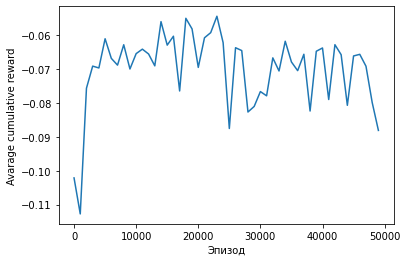

In [144]:
plt.plot(range(0,50000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:05<08:22,  5.08s/it]



  2%|▏         | 2/100 [00:11<08:54,  5.45s/it]



  3%|▎         | 3/100 [00:18<09:30,  5.88s/it]



  4%|▍         | 4/100 [00:25<10:08,  6.34s/it]



  5%|▌         | 5/100 [00:32<10:26,  6.59s/it]



  6%|▌         | 6/100 [00:40<10:37,  6.78s/it]



  7%|▋         | 7/100 [00:48<11:14,  7.25s/it]



  8%|▊         | 8/100 [00:58<12:11,  7.95s/it]



  9%|▉         | 9/100 [01:07<12:41,  8.37s/it]



 10%|█         | 10/100 [01:17<13:21,  8.91s/it]



 11%|█         | 11/100 [01:28<13:58,  9.43s/it]



 12%|█▏        | 12/100 [01:38<14:08,  9.64s/it]



 13%|█▎        | 13/100 [01:49<14:32, 10.02s/it]



 14%|█▍        | 14/100 [02:00<14:55, 10.41s/it]



 15%|█▌        | 15/100 [02:12<15:28, 10.92s/it]



 16%|█▌        | 16/100 [02:24<15:39, 11.18s/it]



 17%|█▋        | 17/100 [02:36<15:47, 11.42s/it]



 18%|█▊        | 18/100 [02:47<15:22, 11.25s/it]



 19%|█▉        | 19/100 [0

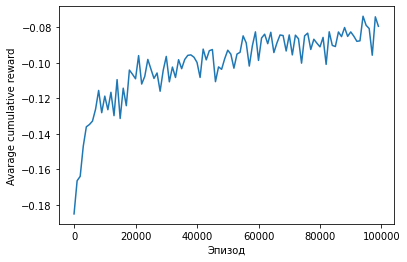

CPU times: user 27min 19s, sys: 12.4 s, total: 27min 32s
Wall time: 27min 39s


In [157]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)
    
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

#### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [236]:
from gym.envs.toy_text.blackjack import cmp, is_bust, is_natural, score, sum_hand
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv


class Doubled_Blackjack_V0_Env(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v0')
        self.action_space = list(range(3))
        super(BlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            state, reward, is_done, _ = self.base_env.step(1)
            if done:
                return state, 2*reward, is_done, _
            else:
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2*reward, is_done, _
        else:
            return self.base_env.step(action)

class HoffmanBlackjackEnv(Doubled_Blackjack_V0_Env):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v0', natural=True)
        self.na = 3
        self.natural = True
        self.action_space = spaces.Discrete(3)
        self.sum_card = 0
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = deck.copy()
        self.card_cost = {
                            1: -1,
                            2: +0.5,
                            3: +1,
                            4: +1,
                            5: +1.5,
                            6: +1,
                            7: +0.5,
                            8: +0,
                            9: -0.5,
                            10: -1,}
        #self.reset()
        super(HoffmanBlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        if len(self.deck) <= 15:
            self.sum_card = 0
            self.deck = deck.copy()
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        self.sum_card += self.card_cost[card]
        return int(card)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
        
    def _get_obs(self):
        return (*super(Doubled_Blackjack_V0_Env, self)._get_obs(), self.sum_card)
    
    def step(self, action):
#         print(type(self.action_space))
#         assert self.action_space.contains(action)
        if action: 
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
                
                
            reward = cmp(score(self.player), score(self.dealer))
            
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, {}

In [237]:
class Qlearning_hoffman():
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.env = HoffmanBlackjackEnv()
        self.na = 3
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for n in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        #print(f"Средний выигрыш после {num_episodes} эпизодов Q-learning: {average_reward}")
        return average_reward

In [263]:
%%time
QL_Hoffman = Qlearning_hoffman()
QL_Hoffman.train(1000000)
QL_Hoffman.inference()

CPU times: user 2min 40s, sys: 1.1 s, total: 2min 41s
Wall time: 2min 42s


-0.048955

In [264]:
env = HoffmanBlackjackEnv()

def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    #print(f"Средний выигрыш после {num_episodes} эпизодов Monte Carlo control: {average_reward}")
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(3))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], 3)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [266]:
Q_mc, evaluations = monte_carlo(episodes=1000000)
MC_inference(Q_mc, num_episodes=100000)

-0.029375000000000245

#### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### Grid search q-learning and plot

In [241]:
%%time
best_sum_of_rewards = -0.18 # need better that dummy strategy
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.0001, 0.01, 10)):
    for eps in np.linspace(0.05, 0.5, 10):
        QL_Hoffman = Qlearning_hoffman(alpha=alpha, eps=eps)
        QL_Hoffman.train(10000)
        sum_of_rewards = QL_Hoffman.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")





  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [01:47<16:06, 107.39s/it]



 20%|██        | 2/10 [03:40<14:33, 109.18s/it]



 30%|███       | 3/10 [05:38<13:01, 111.69s/it]



 40%|████      | 4/10 [07:33<11:17, 112.84s/it]



 50%|█████     | 5/10 [09:31<09:31, 114.26s/it]



 60%|██████    | 6/10 [11:22<07:33, 113.44s/it]



 70%|███████   | 7/10 [13:04<05:29, 109.98s/it]



 80%|████████  | 8/10 [14:48<03:35, 107.97s/it]



 90%|█████████ | 9/10 [16:35<01:47, 107.79s/it]



100%|██████████| 10/10 [18:14<00:00, 109.41s/it]

Лучший выигрыш: -0.12941500000000017, alpha: 0.01, eps: 0.45
CPU times: user 18min 13s, sys: 10.4 s, total: 18min 24s
Wall time: 18min 14s


In [245]:
%%time
QL_Hoffman = Qlearning_hoffman(alpha=0.01, eps=0.45)
sums_of_rewards = []
best_sum_of_rewards = [QL_Hoffman.inference()]
for i in tqdm(range(100)):
    QL_Hoffman.train(1000)
    sum_of_rewards = QL_Hoffman.inference()
    sums_of_rewards.append(sum_of_rewards)





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:09<15:16,  9.26s/it]



  2%|▏         | 2/100 [00:18<15:08,  9.27s/it]



  3%|▎         | 3/100 [00:27<14:38,  9.06s/it]



  4%|▍         | 4/100 [00:36<14:28,  9.05s/it]



  5%|▌         | 5/100 [00:44<14:11,  8.96s/it]



  6%|▌         | 6/100 [00:53<13:59,  8.93s/it]



  7%|▋         | 7/100 [01:03<14:06,  9.10s/it]



  8%|▊         | 8/100 [01:12<13:57,  9.10s/it]



  9%|▉         | 9/100 [01:21<13:36,  8.97s/it]



 10%|█         | 10/100 [01:31<14:01,  9.35s/it]



 11%|█         | 11/100 [01:39<13:32,  9.13s/it]



 12%|█▏        | 12/100 [01:49<13:36,  9.27s/it]



 13%|█▎        | 13/100 [01:58<13:08,  9.07s/it]



 14%|█▍        | 14/100 [02:06<12:53,  9.00s/it]



 15%|█▌        | 15/100 [02:15<12:29,  8.81s/it]



 16%|█▌        | 16/100 [02:23<12:10,  8.69s/it]



 17%|█▋        | 17/100 [02:32<12:04,  8.72s/it]



 18%|█▊        | 18/100 [02:41<11:57,  8.75s/it]



 19%|█▉        | 19/100 [0

CPU times: user 16min 42s, sys: 10.8 s, total: 16min 53s
Wall time: 16min 44s


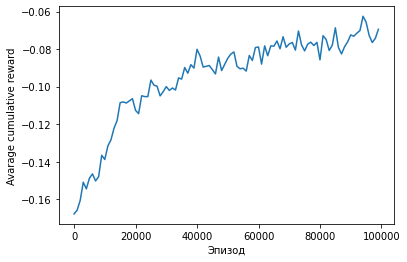

In [246]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

К сожалению, для наглядной демонстрации сходимости нужно на порядок больше эпизодов.





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:09<15:29,  9.39s/it]



  2%|▏         | 2/100 [00:18<15:17,  9.36s/it]



  3%|▎         | 3/100 [00:28<15:18,  9.47s/it]



  4%|▍         | 4/100 [00:38<15:20,  9.59s/it]



  5%|▌         | 5/100 [00:48<15:26,  9.75s/it]



  6%|▌         | 6/100 [00:58<15:40, 10.00s/it]



  7%|▋         | 7/100 [01:09<15:48, 10.20s/it]



  8%|▊         | 8/100 [01:20<15:55, 10.38s/it]



  9%|▉         | 9/100 [01:31<16:02, 10.58s/it]



 10%|█         | 10/100 [01:42<16:08, 10.76s/it]



 11%|█         | 11/100 [01:54<16:14, 10.95s/it]



 12%|█▏        | 12/100 [02:06<16:40, 11.36s/it]



 13%|█▎        | 13/100 [02:19<17:15, 11.90s/it]



 14%|█▍        | 14/100 [02:32<17:28, 12.20s/it]



 15%|█▌        | 15/100 [02:44<17:15, 12.18s/it]



 16%|█▌        | 16/100 [02:56<17:07, 12.23s/it]



 17%|█▋        | 17/100 [03:09<16:59, 12.29s/it]



 18%|█▊        | 18/100 [03:22<17:04, 12.49s/it]



 19%|█▉        | 19/100 [0

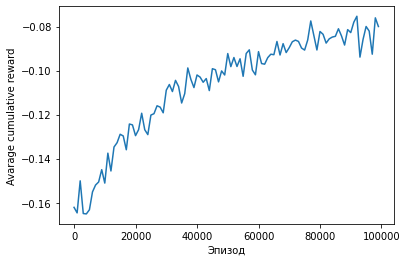

CPU times: user 32min 51s, sys: 16 s, total: 33min 7s
Wall time: 7h 21min 32s


In [267]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)
    
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()